# Which metros have the highest net acquisitions from investors? 

In this notebook, we are going to create a table of the last 6 months of the investor purchase to sale ratio for the top 50 metros. This is a ratio showing investor acquisitions/dispositions.

If investors bought and sold 10 homes in month, 10/10 = 1. No change in purchase to sale ratio. 

If investors bought 10 homes and sold 100 homes, 10/100 = .1. For every home bought, they are selling 10.

Welcome to the Lab - LFG

**Note** This notebook will work with any of the 70k+ markets supported by the Parcl Labs API.

As a reminder, you can get your Parcl Labs API key [here](https://dashboard.parcllabs.com/signup) to follow along. 

In [1]:
import os
from datetime import datetime

import parcllabs
import pandas as pd
import plotly.express as px
from parcllabs import ParclLabsClient

api_key = os.getenv('PARCL_LABS_API_KEY')
print(f"Parcl Labs Version: {parcllabs.__version__}")

Parcl Labs Version: 0.1.14


In [2]:
client = ParclLabsClient(api_key=api_key)

In [3]:
# lets get all metros in the country

metros = client.search_markets.retrieve(
    location_type='CBSA',
    as_dataframe=True,
    params={
        'limit': 1000
    }
)

In [4]:
# get the ids
metro_ids = metros['parcl_id'].tolist()

In [5]:
# get most recent housing stock for all metros
housing_stock = client.market_metrics_housing_stock.retrieve_many(
    parcl_ids=metro_ids,
    params={
        'limit': 1 # let's get the most recent stock
    },
    as_dataframe=True # make life easy on ourselves
)

In [6]:
housing_stock.head()

,date,single_family,condo,townhouse,other,all_properties,parcl_id
0,2024-03-01,2802362,957017,76608,1583688,5419675,2900187
1,2024-03-01,1997656,858838,19719,555526,3431739,2900078
2,2024-03-01,2017899,768604,123514,588914,3498931,2899845
3,2024-03-01,1921281,457709,41641,373657,2794288,2899734
4,2024-03-01,1765489,383733,33520,355410,2538152,2899967


In [7]:
top_50 = housing_stock.sort_values('all_properties', ascending=False).head(50)
metros.head()

,parcl_id,country,geoid,state_fips_code,name,state_abbreviation,region,location_type,total_population,median_income,parcl_exchange_market,pricefeed_market,case_shiller_10_market,case_shiller_20_market
0,2900187,USA,35620,None,"New York-Newark-Jersey City, Ny-Nj-Pa",None,None,CBSA,19908595,93610,0,1,1,1
1,2900078,USA,31080,None,"Los Angeles-Long Beach-Anaheim, Ca",None,None,CBSA,13111917,89105,0,1,1,1
2,2899845,USA,16980,None,"Chicago-Naperville-Elgin, Il-In-Wi",None,None,CBSA,9566955,85087,0,1,1,1
3,2899734,USA,19100,None,"Dallas-Fort Worth-Arlington, Tx",None,None,CBSA,7673379,83398,0,1,0,1
4,2899967,USA,26420,None,"Houston-The Woodlands-Sugar Land, Tx",None,None,CBSA,7142603,78061,0,1,0,0


In [8]:
# investor ownership for these top 100 markets
purchase_to_sale = client.investor_metrics_purchase_to_sale_ratio.retrieve_many(
    parcl_ids=top_50['parcl_id'].tolist(),
    params={
        'limit': 6, # get last 6 mo's 
    },
    as_dataframe=True
)

purchase_to_sale.head()

,date,purchase_to_sale_ratio,parcl_id
0,2024-03-01,1.50,2900187
1,2024-02-01,1.57,2900187
2,2024-01-01,1.61,2900187
3,2023-12-01,1.55,2900187
4,2023-11-01,1.43,2900187


In [9]:
out = pd.merge(metros[['parcl_id', 'name']], purchase_to_sale[['parcl_id',  'date', 'purchase_to_sale_ratio']], on='parcl_id')
out = out.drop('parcl_id', axis=1)
out.head()

,name,date,purchase_to_sale_ratio
0,"New York-Newark-Jersey City, Ny-Nj-Pa",2024-03-01,1.50
1,"New York-Newark-Jersey City, Ny-Nj-Pa",2024-02-01,1.57
2,"New York-Newark-Jersey City, Ny-Nj-Pa",2024-01-01,1.61
3,"New York-Newark-Jersey City, Ny-Nj-Pa",2023-12-01,1.55
4,"New York-Newark-Jersey City, Ny-Nj-Pa",2023-11-01,1.43


In [10]:
def format_names(nme):
    state = nme.split(',')[-1].strip()
    metro = nme.split(',')[0].split('-')[0].strip()
    metro = metro.split('/')[0].strip()
    return metro
    # return f"{metro}, {state}"

out['name'] = out['name'].apply(lambda x: format_names(x))

charting_data = out.pivot_table(values='purchase_to_sale_ratio', index='name', columns='date')
charting_data.index

Index(['Atlanta', 'Austin', 'Baltimore', 'Birmingham', 'Boston', 'Cape Coral',
       'Charlotte', 'Chicago', 'Cincinnati', 'Cleveland', 'Columbus', 'Dallas',
       'Denver', 'Detroit', 'Hartford', 'Houston', 'Indianapolis',
       'Jacksonville', 'Kansas City', 'Las Vegas', 'Los Angeles', 'Louisville',
       'Memphis', 'Miami', 'Milwaukee', 'Minneapolis', 'Nashville',
       'New Orleans', 'New York', 'North Port', 'Oklahoma City', 'Orlando',
       'Philadelphia', 'Phoenix', 'Pittsburgh', 'Portland', 'Providence',
       'Raleigh', 'Richmond', 'Riverside', 'Sacramento', 'San Antonio',
       'San Diego', 'San Francisco', 'San Jose', 'Seattle', 'St. Louis',
       'Tampa', 'Virginia Beach', 'Washington'],
      dtype='object', name='name')

In [11]:
charting_data.head()

date,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01
name,,,,,,
Atlanta,1.72,1.63,1.60,1.45,1.30,0.89
Austin,1.14,1.14,1.18,1.21,0.92,0.98
Baltimore,1.13,1.03,0.91,1.38,0.97,0.95
Birmingham,1.18,1.09,1.23,1.03,1.15,0.99
Boston,0.99,0.97,0.99,1.13,0.97,0.75


In [12]:
charting_data = charting_data.sort_values('2024-03-01', ascending=False)
charting_data

date,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01
name,,,,,,
Pittsburgh,1.17,1.58,1.23,1.76,1.37,1.89
New York,1.51,1.43,1.55,1.61,1.57,1.50
New Orleans,1.83,1.51,1.63,1.66,2.01,1.48
Memphis,1.34,1.19,1.16,1.22,1.27,1.48
Hartford,1.19,1.04,1.22,1.18,0.93,1.31
Cleveland,1.34,1.13,1.18,1.09,1.07,1.24
Denver,1.49,1.49,1.71,1.65,1.25,1.21
San Antonio,1.34,1.23,1.36,1.14,1.16,1.14
Louisville,1.38,1.08,1.42,1.49,1.40,1.09


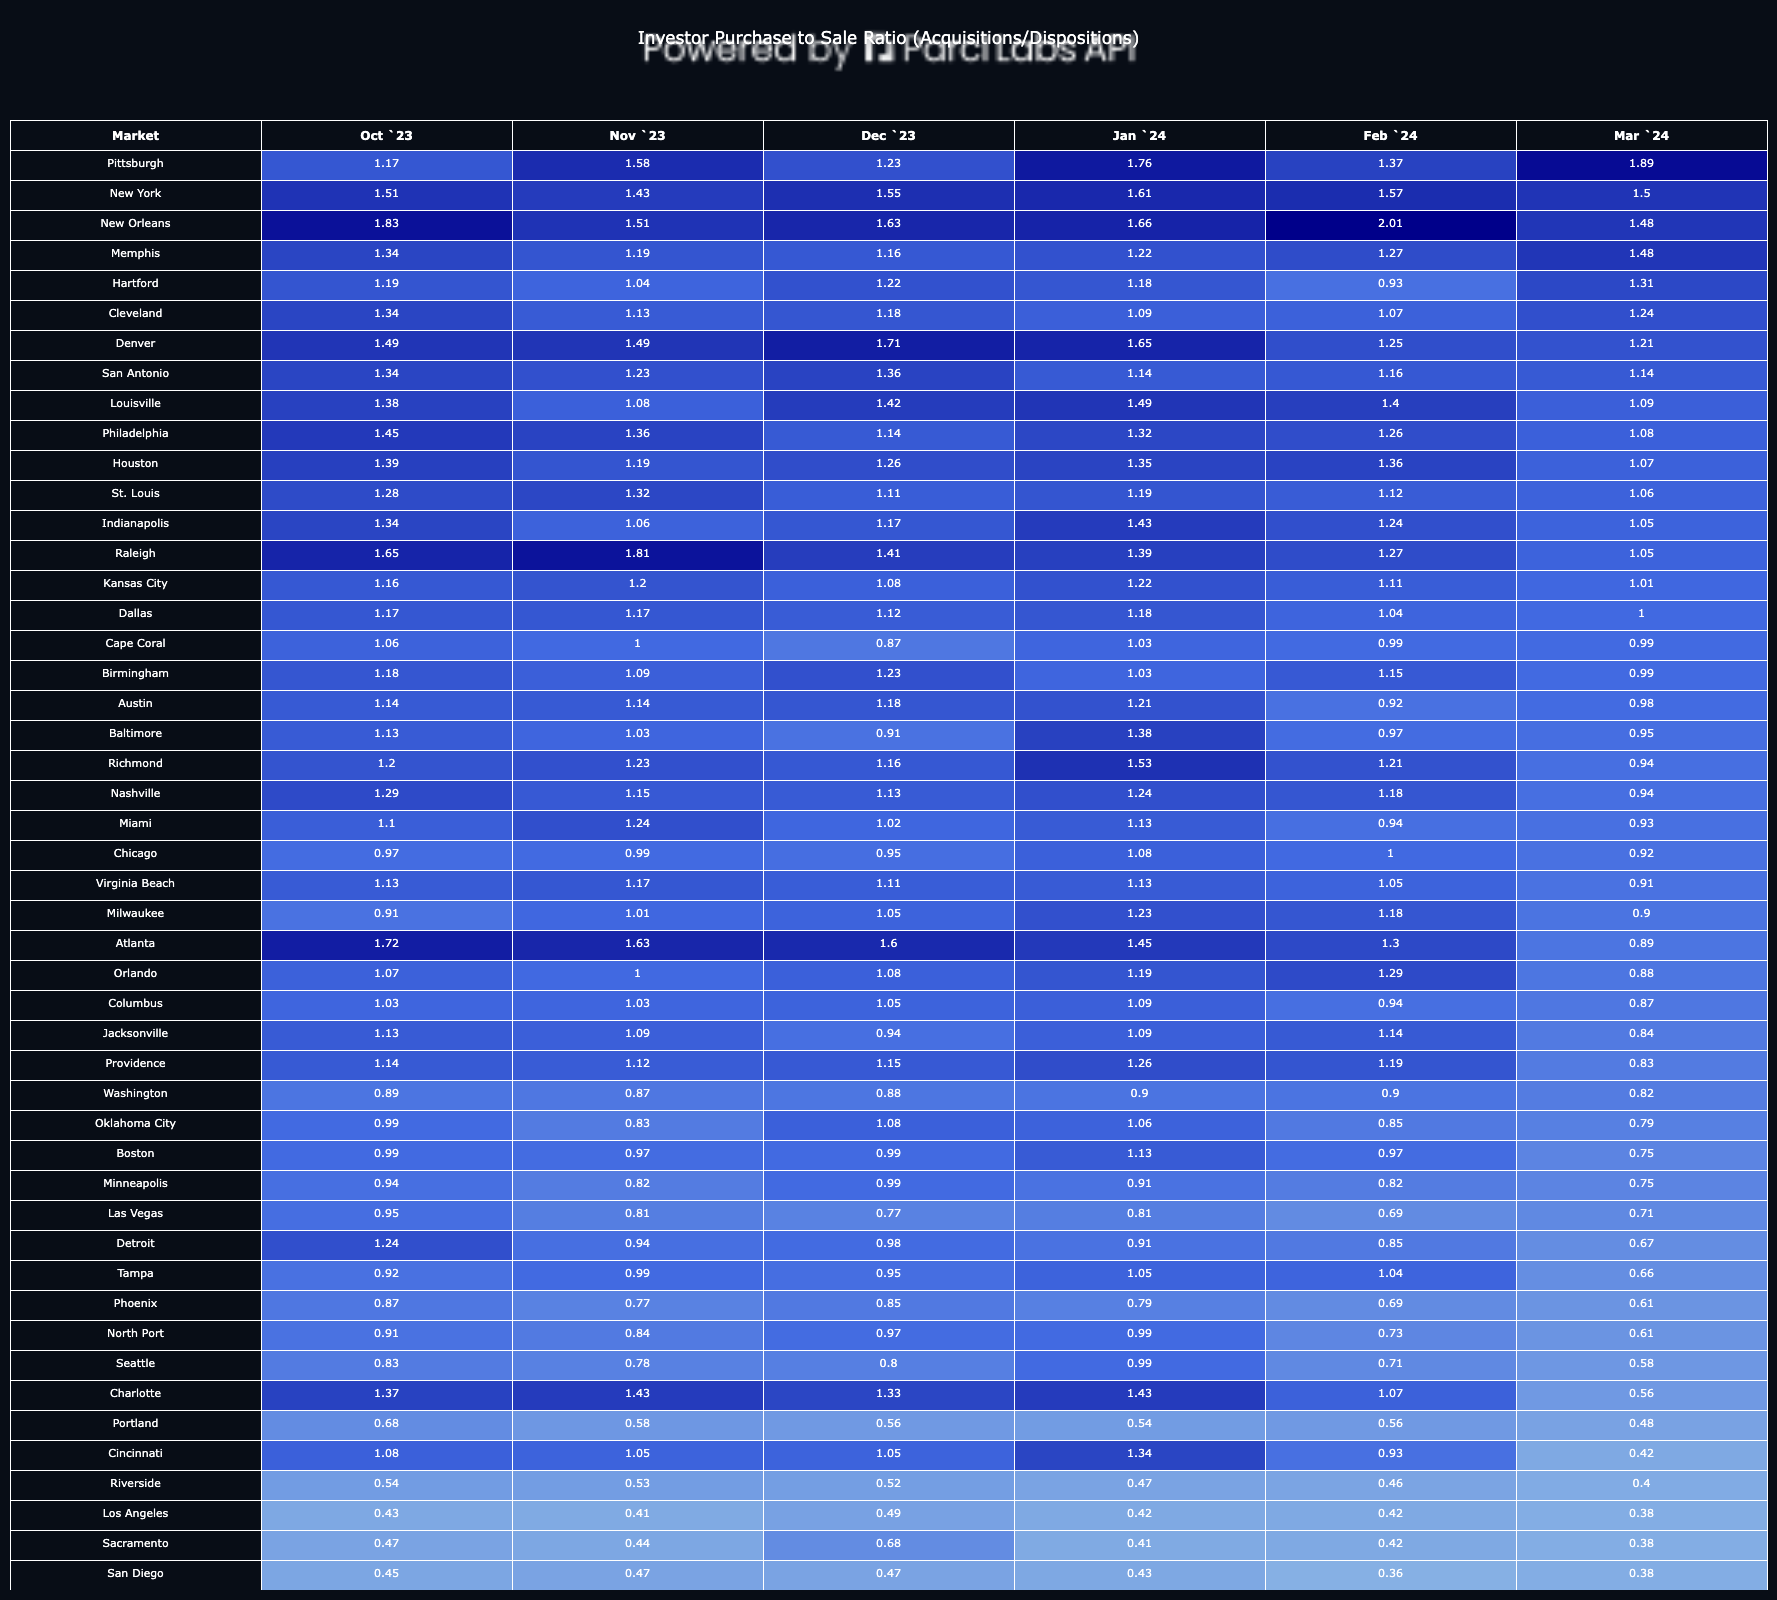

In [15]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from datetime import datetime

# Assuming charting_data is defined and contains data for 50 markets and 6 months

def color_scale(value):
    # Normalize the value to the new range [0, 2] with a midpoint at 1
    if value < 1:
        # Scale from light blue to blue as value approaches 1 from 0
        normalized = value  # No need to normalize since it's already 0 to 1
        r = int(173 + (65 - 173) * normalized)  # Decrease red channel towards darker blue
        g = int(216 + (105 - 216) * normalized)  # Decrease green channel towards darker blue
        b = int(230 + (225 - 230) * normalized)  # Slightly increase blue channel towards 225
    else:
        # Scale from blue to dark blue as value goes from 1 to 2
        normalized = (value - 1) / 1  # Normalize the upper half from 0 to 1
        r = int(65 + (0 - 65) * normalized)  # Decrease red channel towards darkest blue
        g = int(105 + (0 - 105) * normalized)  # Decrease green channel towards darkest blue
        b = int(225 + (139 - 225) * normalized)  # Decrease blue channel towards darker blue

    # Ensure RGB values are within the valid range
    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))

    return f'rgb({r},{g},{b})'



def format_date(date):
    date = datetime.strptime(date, '%Y-%m-%d')
    return date.strftime('%b `' + date.strftime('%y'))

dates = charting_data.columns.tolist()

labs_logo_lookup = {
    'blue': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api.png',
    'white': 'https://parcllabs-assets.s3.amazonaws.com/powered-by-parcllabs-api-logo-white.png'
}

labs_logo_dict = dict(
    source=labs_logo_lookup['white'],
    xref="paper",
    yref="paper",
    x=0.5,
    y=1.02,  # Adjusted for more data
    sizex=0.3,
    sizey=0.2,
    xanchor="center",
    yanchor="bottom"
)

fig = go.Figure(
    data=[go.Table(
        header=dict(
            values=['<b>Market</b>'] + [f"<b>{format_date(date)}</b>" for date in dates],
            fill_color='#080D16',
            font=dict(color='#FFFFFF', size=12),
            align='center',
            height=30
        ),
        cells=dict(
            values=[[f"{name}" for name in charting_data.index]] + 
                   [charting_data[date] for date in dates],
            fill=dict(
                color=[
                    ['#080D16']*len(charting_data.index)] +
                    [[color_scale(charting_data.at[market, date]) for market in charting_data.index] for date in dates]
            ),
            font=dict(
                color='#FFFFFF',
                size=11  # Uniform size for all cells
            ),
            align='center',
            height=30
        ))
])

fig.add_layout_image(labs_logo_dict)

fig.update_layout(
    title={
        'text': 'Investor Purchase to Sale Ratio (Acquisitions/Dispositions)',
        'y': 0.98,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    title_font_color='#FFFFFF',
    width=900,  # Slightly wider to accommodate more columns
    height=1600, # + 100 * len(charting_data.index),  # Adjust height based on the number of markets
    paper_bgcolor='#080D16',
    margin=dict(l=10, r=10, t=120, b=10)
)

fig.show()